In [0]:
PATH = '/content/drive/My Drive/Colab Notebooks/Titanic Survivor Classifier/data/'

In [0]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.utils import shuffle
%matplotlib inline

In [0]:
# Reading train and test data
df_train = pd.read_csv(PATH+'train.csv')  # 0 - 890
df_test = pd.read_csv(PATH+'test.csv')  # 0 - 417
df_train = shuffle(df_train)

# Adding a Survived column in test data 
lst = np.zeros(len(df_test), dtype=int)
df_test.insert(loc=1, column='Survived', value=lst)

# Adding test data to the train data for consistent data manipulation 
df = df_train.append(df_test)

# Cleaning data 
df.drop(['PassengerId', 'Name', 'Cabin'], axis = 1, inplace=True)
df['Age']=df['Age'].fillna(df['Age'].mean())
df['Sex'] = df['Sex'].replace('male', 0)
df['Sex'] = df['Sex'].replace('female', 1)
df['Embarked'] = df['Embarked'].replace('S',0)
df['Embarked'] = df['Embarked'].replace('C',1)
df['Embarked'] = df['Embarked'].replace('Q',2)
df.fillna(0, inplace=True)

categorical_cols = df.select_dtypes('object').columns.to_list()

In [0]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[dataframe1.columns[1:]].to_numpy()
    targets_array = dataframe1[dataframe1.columns[0]].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = dataframe_to_arrays(df)

inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.long)

train_ds = TensorDataset(inputs[0:691], targets[0:691])
val_ds = TensorDataset(inputs[691:891], targets[691:891]) 
test_ds = TensorDataset(inputs[891:], targets[891:])

batch_size=32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, 418, num_workers=4, pin_memory=True)

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

class TitanicModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,hidden_size)
        self.linear4 = nn.Linear(hidden_size, output_size)
        
    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        features, labels = batch 
        out = self(features)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        out = self(features)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [0]:
input_size = 8
hidden_size = 128 
num_classes = 2

model = TitanicModel(input_size, hidden_size=32, output_size=num_classes)

In [7]:
for inputs, targets in train_loader:
    outputs = model(inputs)
    loss = F.cross_entropy(outputs, targets)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 5.489340782165527
outputs.shape :  torch.Size([32, 2])
Sample outputs :
 tensor([[10.1673,  3.5274],
        [10.7064,  3.9596]])


In [8]:
history = [evaluate(model, val_loader)]

history += fit(150, 1e-3, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8740, val_acc: 0.3477
Epoch [1], val_loss: 0.5933, val_acc: 0.7070
Epoch [2], val_loss: 0.5455, val_acc: 0.7656
Epoch [3], val_loss: 0.5415, val_acc: 0.7734
Epoch [4], val_loss: 0.5263, val_acc: 0.7734
Epoch [5], val_loss: 0.6157, val_acc: 0.7109
Epoch [6], val_loss: 0.9006, val_acc: 0.3750
Epoch [7], val_loss: 0.5942, val_acc: 0.7344
Epoch [8], val_loss: 0.5236, val_acc: 0.7695
Epoch [9], val_loss: 0.5216, val_acc: 0.7773
Epoch [10], val_loss: 0.5231, val_acc: 0.7539
Epoch [11], val_loss: 0.5204, val_acc: 0.7773
Epoch [12], val_loss: 0.5848, val_acc: 0.7383
Epoch [13], val_loss: 0.5363, val_acc: 0.7578
Epoch [14], val_loss: 0.5138, val_acc: 0.7578
Epoch [15], val_loss: 0.5174, val_acc: 0.7891
Epoch [16], val_loss: 0.5153, val_acc: 0.7695
Epoch [17], val_loss: 0.5196, val_acc: 0.7734
Epoch [18], val_loss: 0.5287, val_acc: 0.7578
Epoch [19], val_loss: 0.6097, val_acc: 0.7539
Epoch [20], val_loss: 0.5091, val_acc: 0.7656
Epoch [21], val_loss: 0.5288, val_acc: 0.796

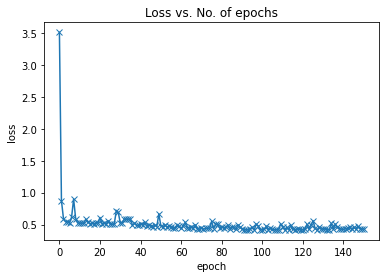

In [9]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

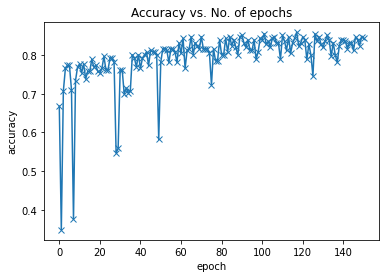

In [10]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

**Submission**

In [0]:
for features,_ in test_loader:
    a = model(features)
b = torch.topk(a,k=1)

In [0]:
y = []
for i in range(len(b[1])):
  y.append(b[1][i].item())

In [0]:
submission = pd.DataFrame({ 'PassengerId': [i for i in range(892,892 + len(y))], 'Survived': [i for i in y] })
submission.to_csv("submission4.csv", index=False)